100
[Step 10/100] Immediate Loss: 7.798764485716818 Accumlated Loss: 10.695049868911504
[Step 20/100] Immediate Loss: 7.175654533207414 Accumlated Loss: 7.41971659642458
[Step 30/100] Immediate Loss: 7.064808929860589 Accumlated Loss: 7.102920457333326
[Step 40/100] Immediate Loss: 7.0074234905839 Accumlated Loss: 6.9630768875181674
[Step 50/100] Immediate Loss: 6.9895634829998015 Accumlated Loss: 6.904858220517634
[Step 60/100] Immediate Loss: 6.930768578052519 Accumlated Loss: 6.851308759361505
[Step 70/100] Immediate Loss: 6.801801775097844 Accumlated Loss: 6.917650807946919
[Step 80/100] Immediate Loss: 6.898209309875968 Accumlated Loss: 6.852221962392329
[Step 90/100] Immediate Loss: 6.877323675155637 Accumlated Loss: 6.880460332095623
[Step 100/100] Immediate Loss: 6.808387375473978 Accumlated Loss: 6.813448920100927


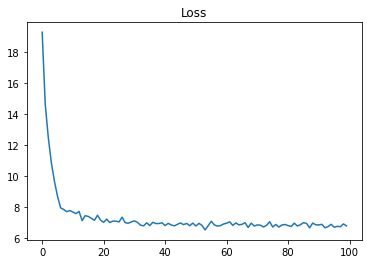

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal

random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        
        # guide 1
        self.hidden_size_1 = 8
        self.x1_net_1 = simpleNN()
        self.x2_net_1 = simpleNN()
        self.x3_net_1 = simpleNN()
        self.x4_net_1 = simpleNN()
        self.x5_net_1 = simpleNN()
        self.x6_net_1 = simpleNN()
        self.x7_net_1 = simpleNN()
        self.x8_net_1 = simpleNN()
        self.y1_net_1 = simpleNN()
        self.y2_net_1 = simpleNN()
        self.y3_net_1 = simpleNN()
        self.y4_net_1 = simpleNN()
        self.z1_net_1 = simpleNN(self.hidden_size_1 + 1)
        self.z2_net_1 = simpleNN(self.hidden_size_1 + 1)
        
        self.h0_1 = nn.Parameter(torch.zeros(self.hidden_size_1))
        self.hid_net_1 = simpleNN(self.hidden_size_1 + 8, out_size = self.hidden_size_1, t = "mlp")
        
        # guide 2
        self.hidden_size_2 = 8
        self.x1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x3_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x4_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x5_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x6_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x7_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.x8_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y3_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.y4_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.z1_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.z2_net_2 = simpleNN(self.hidden_size_2 + 1)
        self.h0_2 = nn.Parameter(torch.zeros(self.hidden_size_2))
        self.hid_net_2 = simpleNN(self.hidden_size_2 + 8, out_size = self.hidden_size_2, t = "mlp")
        
        # guide 3
        self.hidden_size_3 = 8
        self.x1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x3_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x4_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x5_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x6_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.x7_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.x8_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.y1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.y2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.y3_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.y4_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.z1_net_3 = simpleNN(self.hidden_size_3 + 2)
        self.z2_net_3 = simpleNN(self.hidden_size_3 + 1)
        self.h0_3 = nn.Parameter(torch.zeros(self.hidden_size_3))
        self.hid_net_3 = simpleNN(self.hidden_size_3 + 8, out_size = self.hidden_size_3, t = "mlp")

        # guide 4
        self.hidden_size_4 = 8
        self.x1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x3_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x4_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x5_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x6_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.x7_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.x8_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.y1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.y2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.y3_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.y4_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.z1_net_4 = simpleNN(self.hidden_size_4 + 2)
        self.z2_net_4 = simpleNN(self.hidden_size_4 + 1)
        self.h0_4 = nn.Parameter(torch.zeros(self.hidden_size_4))
        self.hid_net_4 = simpleNN(self.hidden_size_4 + 8 + 4 + 2, out_size = self.hidden_size_4, t = "mlp")
        
        # guide 5
        self.hidden_size_5 = 16
        self.x1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x3_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x4_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x5_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x6_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.x7_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.x8_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.y1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.y2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.y3_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.y4_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.z1_net_5 = simpleNN(self.hidden_size_5 + 2)
        self.z2_net_5 = simpleNN(self.hidden_size_5 + 1)
        self.h0_5 = nn.Parameter(torch.zeros(self.hidden_size_5))
        self.hid_net_5 = simpleNN(self.hidden_size_5 + 8 + 4 + 2, out_size = self.hidden_size_5, t = "mlp")
        
        # guide 6
        self.hidden_size_6 = 8
        self.x1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x3_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x4_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x5_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x6_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.x7_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.x8_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.y1_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.y2_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.y3_net_6 = simpleNN(self.hidden_size_6 + 2)
        self.y4_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.z1_net_6 = simpleNN(self.hidden_size_6 + 1)
        self.z2_net_6 = simpleNN(self.hidden_size_6)
        self.z1_net_6_last = simpleNN(self.hidden_size_6 + 2)
        self.z2_net_6_last = simpleNN(self.hidden_size_6 + 1)
        self.h0_6 = nn.Parameter(torch.zeros(self.hidden_size_6))
        self.hid_net_6 = simpleNN(self.hidden_size_6 + 8 + 4 + 2 + 1, out_size = self.hidden_size_6, t = "mlp")
        self.hid_net_6_5 = simpleNN(self.hidden_size_6 + 8 + 4 + 2, out_size = self.hidden_size_6, t = "mlp")
    
        # guide 7
        self.hidden_size_7 = 8
        self.x1_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.x2_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.x3_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.x4_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.x5_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.x6_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.x7_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.x8_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.y1_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.y2_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.y3_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.y4_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.z1_net_7 = simpleNN(self.hidden_size_7 + 2)
        self.z2_net_7 = simpleNN(self.hidden_size_7 + 1)
        self.h0_7 = nn.Parameter(torch.zeros(self.hidden_size_6))
        self.hid_net_7 = simpleNN(self.hidden_size_7 + 2, out_size = self.hidden_size_7, t = "mlp")
        
    def model(self, n, obs):
        def tree_model(i, mu):
            x1 = pyro.sample(f"x1{i}", dist.Normal(mu, 1.0))
            x2 = pyro.sample(f"x2{i}", dist.Normal(mu, 1.0))
            x3 = pyro.sample(f"x3{i}", dist.Normal(mu, 1.0))
            x4 = pyro.sample(f"x4{i}", dist.Normal(mu, 1.0))
            x5 = pyro.sample(f"x5{i}", dist.Normal(mu, 1.0))
            x6 = pyro.sample(f"x6{i}", dist.Normal(mu, 1.0))
            x7 = pyro.sample(f"x7{i}", dist.Normal(mu, 1.0))
            x8 = pyro.sample(f"x8{i}", dist.Normal(mu, 1.0))
            y1 = pyro.sample(f"y1{i}", dist.Normal(x1+x2, 1.0))
            y2 = pyro.sample(f"y2{i}", dist.Normal(x3+x4, 1.0))
            y3 = pyro.sample(f"y3{i}", dist.Normal(x5+x6, 1.0))
            y4 = pyro.sample(f"y4{i}", dist.Normal(x7+x8, 1.0))
            z1 = pyro.sample(f"z1{i}", dist.Normal(y1+y2, 1.0))
            z2 = pyro.sample(f"z2{i}", dist.Normal(y3+y4, 1.0))
            return z1 + z2  
            
        pyro.module("model", self)
        mu = 0
        for i in range(n):
            mu = tree_model(i, mu)
        
        pyro.sample("obs", dist.Normal(mu, 1.0), obs=obs)
    
    # guide 1 basically inverse the arrows in the model, add hidden states that z2 depends on
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    def guide_1(self, n, obs):
        
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_1([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_1([obs, hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_1([z2])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_1([z2])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_1([z1])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_1([z1])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_1([y4])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_1([y4])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_1([y3])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_1([y3])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_1([y2])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_1([y2])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_1([y1])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_1([y1])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_1([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_1
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide_1_1 basically inverse the arrows in the model, add hidden states that z2 depends on
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # different from guide_1 by sample from i = n-1, n-2, ..., 0
    def guide_1_1(self, n, obs):
        
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_1([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_1([obs, hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_1([z2])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_1([z2])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_1([z1])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_1([z1])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_1([y4])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_1([y4])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_1([y3])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_1([y3])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_1([y2])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_1([y2])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_1([y1])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_1([y1])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_1([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_1
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid)
    
    # guide 2 basically inverse the arrows in the model, add hidden states that each RV
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    def guide_2(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_2([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_2([obs, hid])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_2([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_2([z2, hid])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_2([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_2([z1, hid])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_2([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_2([y4, hid])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_2([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_2([y3, hid])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_2([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_2([y2, hid])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_2([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_2([y1, hid])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_2([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_2
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 3 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = 0, 1, ..., n-2, n-1
    
    def guide_3(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_3([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_3([obs, hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_3([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_3([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_3([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_3([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_3([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_3([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_3([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_3([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_3([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_3([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_3([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_3([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_3([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_3
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 3_1 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled xs (x1,x2...x8)
    # sample from i = n-1, n-2, ..., 1, 0
    
    def guide_3_1(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_3([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_3([obs, hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_3([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_3([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_3([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_3([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_3([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_3([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_3([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_3([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_3([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_3([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_3([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_3([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_3([hid, x1, x2, x3, x4, x5, x6, x7, x8])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_3
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid)
    
    # guide 4 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2)
    # sample from i = 0, 1, ..., n-2, n-1
    
    def guide_4(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_4([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_4([obs, hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_4([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_4([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_4([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_4([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_4([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_4([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_4([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_4([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_4([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_4([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_4([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_4([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_4([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_4
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 5 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2)
    # sample from i = 0, 1, ..., n-2, n-1
    # increases hidden state dim from 8 to 16
    def guide_5(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_5([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_5([obs, hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_5([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_5([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_5([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_5([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_5([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_5([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_5([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_5([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_5([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_5([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_5([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_5([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_5([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_5
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # guide 6 basically inverse the arrows in the model, add hidden states that each RV
    # each RV also dependes on its neighbour at the same level
    # similar to guide_4 in tree
    # hid dependes on its old values and all sampled RVs in current iteration (x1,x2...x8, y1,...y4, z1,z2, obs)
    # sample from i = 0, 1, ..., n-2, n-1
    # different from guide_4 by adding obses[i] as an extra dependecy when updating hid

    def guide_6(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_6([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_6([obs, hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_6([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_6([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_6([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_6([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_6([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_6([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_6([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_6([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_6([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_6([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_6([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_6([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_6([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_6
        for i in range(n):
            hid = tree_guide(i, hid)
    
    # reverse order of guide 6
    def guide_6_1(self, n, obs):
        def tree_guide(i, hid, last=False):
            if last: # n-1 iteration
                z2_mean, z2_std = self.z2_net_6_last([obs, hid])
                z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
                z1_mean, z1_std = self.z1_net_6_last([obs, hid, z2])
                z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            else:
                z2_mean, z2_std = self.z2_net_6([hid])
                z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
                z1_mean, z1_std = self.z1_net_6([hid, z2])
                z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
                
            y4_mean, y4_std = self.y4_net_6([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_6([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_6([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_6([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_6([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_6([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_6([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_6([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_6([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_6([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_6([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_6([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_6([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2, obs])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_6
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid, i==n-1)
    
     # reverse order of guide 5
    def guide_5_1(self, n, obs):
        def tree_guide(i, hid, last=False):
            if last: # n-1 iteration
                z2_mean, z2_std = self.z2_net_6_last([obs, hid])
                z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
                z1_mean, z1_std = self.z1_net_6_last([obs, hid, z2])
                z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            else:
                z2_mean, z2_std = self.z2_net_6([hid])
                z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
                z1_mean, z1_std = self.z1_net_6([hid, z2])
                z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
                
            y4_mean, y4_std = self.y4_net_6([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_6([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_6([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_6([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_6([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_6([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_6([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_6([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_6([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_6([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_6([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_6([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_6_5([hid, x1, x2, x3, x4, x5, x6, x7, x8, y1, y2, y3, y4, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_6
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid, i==n-1)
            
    # reverse order of guide 6
    def guide_7_1(self, n, obs):
        def tree_guide(i, hid):
            z2_mean, z2_std = self.z2_net_7([obs, hid])
            z2 = pyro.sample(f"z2{i}", dist.Normal(z2_mean, z2_std))
            z1_mean, z1_std = self.z1_net_7([obs, hid, z2])
            z1 = pyro.sample(f"z1{i}", dist.Normal(z1_mean, z1_std))
            y4_mean, y4_std = self.y4_net_7([z2, hid])
            y4 = pyro.sample(f"y4{i}", dist.Normal(y4_mean, y4_std))
            y3_mean, y3_std = self.y3_net_7([z2, hid, y4])
            y3 = pyro.sample(f"y3{i}", dist.Normal(y3_mean, y3_std))
            y2_mean, y2_std = self.y2_net_7([z1, hid])
            y2 = pyro.sample(f"y2{i}", dist.Normal(y2_mean, y2_std))
            y1_mean, y1_std = self.y1_net_7([z1, hid, y2])
            y1 = pyro.sample(f"y1{i}", dist.Normal(y1_mean, y1_std))
            x8_mean, x8_std = self.x8_net_7([y4, hid])
            x8 = pyro.sample(f"x8{i}", dist.Normal(x8_mean, x8_std))
            x7_mean, x7_std = self.x7_net_7([y4, hid, x8])
            x7 = pyro.sample(f"x7{i}", dist.Normal(x7_mean, x7_std))
            x6_mean, x6_std = self.x6_net_7([y3, hid])
            x6 = pyro.sample(f"x6{i}", dist.Normal(x6_mean, x6_std))
            x5_mean, x5_std = self.x5_net_7([y3, hid, x6])
            x5 = pyro.sample(f"x5{i}", dist.Normal(x5_mean, x5_std))
            x4_mean, x4_std = self.x4_net_7([y2, hid])
            x4 = pyro.sample(f"x4{i}", dist.Normal(x4_mean, x4_std))
            x3_mean, x3_std = self.x3_net_7([y2, hid, x4])
            x3 = pyro.sample(f"x3{i}", dist.Normal(x3_mean, x3_std))
            x2_mean, x2_std = self.x2_net_7([y1, hid])
            x2 = pyro.sample(f"x2{i}", dist.Normal(x2_mean, x2_std))
            x1_mean, x1_std = self.x1_net_7([y1, hid, x2])
            x1 = pyro.sample(f"x1{i}", dist.Normal(x1_mean, x1_std))
            hid = self.hid_net_7([hid, z1, z2])
            return hid
            
        pyro.module("model", self)
        hid = self.h0_7
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid)

def generate_data():
    
    n_min = 2
    n_max = 4
    n = random.randint(n_min, n_max)
    mu = 0
    x_len = 8
    for i in range(n):
        x_noise = torch.randn(x_len) / 4
        x_mean = torch.zeros(x_len) + mu
        xs = torch.normal(x_mean, 1) + x_noise
        ys = []
        j = 0
        while j < len(xs):
            y = dist.Normal(xs[j] + xs[j+1], 2).sample()
            ys.append(y)
            j +=2
        
        zs = []
        j = 0
        while j < len(ys):
            z = dist.Normal(ys[j] + ys[j+1], 1.5).sample()
            zs.append(z)
            j +=2
        
        
        mu = dist.Normal(zs[0] + zs[1], 1).sample() / 10
        
    return n, mu
    
data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

print(len(data))
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_5_1 # guide_1

#guide = AutoNormal(experiment.model)
#guide = AutoMultivariateNormal(experiment.model)
#guide = AutoDiagonalNormal(experiment.model)

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())


n_steps = 100
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for n, obs in data:
        imme_loss += svi.step(n, obs) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

In [2]:
# guide 1
[Step 10/100] Immediate Loss: 16.603609305918223 Accumlated Loss: 17.500606958180665
[Step 20/100] Immediate Loss: 16.855222098529346 Accumlated Loss: 16.53769266751409
[Step 30/100] Immediate Loss: 16.61340282350778 Accumlated Loss: 16.44754036000371
[Step 40/100] Immediate Loss: 16.639495956003664 Accumlated Loss: 16.511027759164573
[Step 50/100] Immediate Loss: 16.672798728644846 Accumlated Loss: 16.288147088468072
[Step 60/100] Immediate Loss: 15.51634753286839 Accumlated Loss: 16.147792665868998
[Step 70/100] Immediate Loss: 16.15346024602652 Accumlated Loss: 16.479967122495175
[Step 80/100] Immediate Loss: 16.921821166276924 Accumlated Loss: 16.31915638077259
[Step 90/100] Immediate Loss: 16.854187341928487 Accumlated Loss: 16.46668990969658
[Step 100/100] Immediate Loss: 16.871344230473042 Accumlated Loss: 16.57739174258709

SyntaxError: invalid syntax (<ipython-input-2-f53fe101f39d>, line 2)

In [ ]:
# guide_1_1
[Step 10/100] Immediate Loss: 15.405036453008657 Accumlated Loss: 16.567898606568573
[Step 20/100] Immediate Loss: 15.315322809517381 Accumlated Loss: 14.818533999025824
[Step 30/100] Immediate Loss: 15.073404014706613 Accumlated Loss: 14.959100090563297
[Step 40/100] Immediate Loss: 15.015228279531001 Accumlated Loss: 14.96936491960287
[Step 50/100] Immediate Loss: 14.918855044841766 Accumlated Loss: 14.759386096328498
[Step 60/100] Immediate Loss: 14.40674435824156 Accumlated Loss: 14.771602175533772
[Step 70/100] Immediate Loss: 15.165615375936037 Accumlated Loss: 14.7810275374949
[Step 80/100] Immediate Loss: 15.034084392786028 Accumlated Loss: 14.678286084234713
[Step 90/100] Immediate Loss: 15.191696979701518 Accumlated Loss: 14.863868380397557
[Step 100/100] Immediate Loss: 15.040978074073792 Accumlated Loss: 14.984134002029897

In [ ]:
# guide 2
[Step 10/100] Immediate Loss: 16.53637493014335 Accumlated Loss: 17.82483194971085
[Step 20/100] Immediate Loss: 16.898313095867625 Accumlated Loss: 16.53944434913993
[Step 30/100] Immediate Loss: 16.60898330211639 Accumlated Loss: 16.47968623232841
[Step 40/100] Immediate Loss: 16.916094422936442 Accumlated Loss: 16.544766229629516
[Step 50/100] Immediate Loss: 16.653268249630926 Accumlated Loss: 16.30891268196702
[Step 60/100] Immediate Loss: 15.60279467880726 Accumlated Loss: 16.188707690000534
[Step 70/100] Immediate Loss: 16.153162809610365 Accumlated Loss: 16.51425990137458
[Step 80/100] Immediate Loss: 16.824226024448862 Accumlated Loss: 16.28886511611939
[Step 90/100] Immediate Loss: 16.817774320542814 Accumlated Loss: 16.44661551308632
[Step 100/100] Immediate Loss: 16.876233668029304 Accumlated Loss: 16.555098087757827

In [ ]:
# guide 3
[Step 10/100] Immediate Loss: 8.415327407419678 Accumlated Loss: 11.498703305780886
[Step 20/100] Immediate Loss: 8.043657022416593 Accumlated Loss: 8.405316677957774
[Step 30/100] Immediate Loss: 8.108019524812699 Accumlated Loss: 8.060190771579743
[Step 40/100] Immediate Loss: 7.697562502324582 Accumlated Loss: 7.9920230777263646
[Step 50/100] Immediate Loss: 7.802509233653544 Accumlated Loss: 7.910115442633629
[Step 60/100] Immediate Loss: 7.558712151944635 Accumlated Loss: 7.8478527779877165
[Step 70/100] Immediate Loss: 7.722976427972315 Accumlated Loss: 7.957533201217653
[Step 80/100] Immediate Loss: 8.078438448607923 Accumlated Loss: 7.904014632731676
[Step 90/100] Immediate Loss: 7.835504165589809 Accumlated Loss: 7.93654251345992
[Step 100/100] Immediate Loss: 8.02648012071848 Accumlated Loss: 7.913111192643644

In [ ]:
# guide 3_1
[Step 10/100] Immediate Loss: 7.976721602976321 Accumlated Loss: 11.208176284015178
[Step 20/100] Immediate Loss: 7.340050332546234 Accumlated Loss: 7.611965912491085
[Step 30/100] Immediate Loss: 7.174539146125315 Accumlated Loss: 7.194422878086567
[Step 40/100] Immediate Loss: 6.969421552419663 Accumlated Loss: 7.003796048998833
[Step 50/100] Immediate Loss: 6.85749923378229 Accumlated Loss: 6.960429052740335
[Step 60/100] Immediate Loss: 6.770355449914931 Accumlated Loss: 6.947518035501241
[Step 70/100] Immediate Loss: 6.968021876811979 Accumlated Loss: 6.909947348475457
[Step 80/100] Immediate Loss: 6.7442953109741195 Accumlated Loss: 6.852114373832941
[Step 90/100] Immediate Loss: 7.055515655577184 Accumlated Loss: 6.904237525612117
[Step 100/100] Immediate Loss: 6.855357233881947 Accumlated Loss: 6.878291214913128

In [ ]:
# guide 4
[Step 10/100] Immediate Loss: 8.412366735637185 Accumlated Loss: 11.58804526951909
[Step 20/100] Immediate Loss: 7.620528174340723 Accumlated Loss: 8.117158968150616
[Step 30/100] Immediate Loss: 7.507575120925904 Accumlated Loss: 7.495831482052805
[Step 40/100] Immediate Loss: 7.241149998307226 Accumlated Loss: 7.271010927528143
[Step 50/100] Immediate Loss: 7.176193792521955 Accumlated Loss: 7.2575744364559664
[Step 60/100] Immediate Loss: 7.031586802303793 Accumlated Loss: 7.2102126263678095
[Step 70/100] Immediate Loss: 7.122065619230268 Accumlated Loss: 7.232378738999365
[Step 80/100] Immediate Loss: 7.09476718723774 Accumlated Loss: 7.145543646603825
[Step 90/100] Immediate Loss: 7.227772540450097 Accumlated Loss: 7.208026203006506
[Step 100/100] Immediate Loss: 7.177712733447549 Accumlated Loss: 7.156796397238969

In [ ]:
# guide 5
[Step 10/100] Immediate Loss: 7.679914959967138 Accumlated Loss: 11.146925537139177
[Step 20/100] Immediate Loss: 7.402561833262443 Accumlated Loss: 7.687605341851713
[Step 30/100] Immediate Loss: 7.527886668145655 Accumlated Loss: 7.457448011845348
[Step 40/100] Immediate Loss: 7.222513418495657 Accumlated Loss: 7.313801758021116
[Step 50/100] Immediate Loss: 7.16132085621357 Accumlated Loss: 7.257306525290014
[Step 60/100] Immediate Loss: 6.999031591117379 Accumlated Loss: 7.231975407689809
[Step 70/100] Immediate Loss: 7.138659704625605 Accumlated Loss: 7.257016090214251
[Step 80/100] Immediate Loss: 7.159046270549299 Accumlated Loss: 7.169736366331577
[Step 90/100] Immediate Loss: 7.258842664659023 Accumlated Loss: 7.2010674090683455
[Step 100/100] Immediate Loss: 7.179027948081492 Accumlated Loss: 7.147476496934891

In [ ]:
# guide 6
[Step 10/100] Immediate Loss: 8.04401047885418 Accumlated Loss: 11.082960224151615
[Step 20/100] Immediate Loss: 7.350265638232232 Accumlated Loss: 7.690995964407919
[Step 30/100] Immediate Loss: 7.354677459895612 Accumlated Loss: 7.346195358514786
[Step 40/100] Immediate Loss: 7.319640446305273 Accumlated Loss: 7.257187823802232
[Step 50/100] Immediate Loss: 7.114424621164799 Accumlated Loss: 7.2349098056256755
[Step 60/100] Immediate Loss: 7.000591119229795 Accumlated Loss: 7.190674315929415
[Step 70/100] Immediate Loss: 7.1216690900921815 Accumlated Loss: 7.242568220317363
[Step 80/100] Immediate Loss: 7.07743655323982 Accumlated Loss: 7.168465733110905
[Step 90/100] Immediate Loss: 7.276139043867588 Accumlated Loss: 7.185225244760513
[Step 100/100] Immediate Loss: 7.260971570909022 Accumlated Loss: 7.150297306448221

In [ ]:
# guide 5_1 new (no obs in hid)
[Step 10/100] Immediate Loss: 7.798764485716818 Accumlated Loss: 10.695049868911504
[Step 20/100] Immediate Loss: 7.175654533207414 Accumlated Loss: 7.41971659642458
[Step 30/100] Immediate Loss: 7.064808929860589 Accumlated Loss: 7.102920457333326
[Step 40/100] Immediate Loss: 7.0074234905839 Accumlated Loss: 6.9630768875181674
[Step 50/100] Immediate Loss: 6.9895634829998015 Accumlated Loss: 6.904858220517634
[Step 60/100] Immediate Loss: 6.930768578052519 Accumlated Loss: 6.851308759361505
[Step 70/100] Immediate Loss: 6.801801775097844 Accumlated Loss: 6.917650807946919
[Step 80/100] Immediate Loss: 6.898209309875968 Accumlated Loss: 6.852221962392329
[Step 90/100] Immediate Loss: 6.877323675155637 Accumlated Loss: 6.880460332095623
[Step 100/100] Immediate Loss: 6.808387375473978 Accumlated Loss: 6.813448920100927

In [ ]:
### guide 6_1 (not faithful minimum z_{n-2} depends on obs)
[Step 10/100] Immediate Loss: 7.885890662968158 Accumlated Loss: 11.057994169056414
[Step 20/100] Immediate Loss: 7.1814592292904855 Accumlated Loss: 7.406067954629658
[Step 30/100] Immediate Loss: 7.0591789925098425 Accumlated Loss: 7.035171322673558
[Step 40/100] Immediate Loss: 6.9713214033842075 Accumlated Loss: 6.915649327993392
[Step 50/100] Immediate Loss: 6.843805762827397 Accumlated Loss: 6.919330851316452
[Step 60/100] Immediate Loss: 6.76589316159487 Accumlated Loss: 6.893545565813779
[Step 70/100] Immediate Loss: 6.883703918159004 Accumlated Loss: 6.874835347026586
[Step 80/100] Immediate Loss: 6.6349282276630435 Accumlated Loss: 6.812026571363211
[Step 90/100] Immediate Loss: 7.005292106866837 Accumlated Loss: 6.86639387100935
[Step 100/100] Immediate Loss: 6.807221605777738 Accumlated Loss: 6.843064952969551

In [ ]:
### guide 6_1 new
[Step 10/100] Immediate Loss: 8.034564805030824 Accumlated Loss: 10.936746909648178
[Step 20/100] Immediate Loss: 7.2499518311023685 Accumlated Loss: 7.311040770947934
[Step 30/100] Immediate Loss: 7.010845541954039 Accumlated Loss: 7.095756838709114
[Step 40/100] Immediate Loss: 7.101395113170147 Accumlated Loss: 6.971324785619975
[Step 50/100] Immediate Loss: 6.966120596230027 Accumlated Loss: 6.913172000795602
[Step 60/100] Immediate Loss: 7.045844776928422 Accumlated Loss: 6.8633523593246935
[Step 70/100] Immediate Loss: 6.736625478863718 Accumlated Loss: 6.842792760789395
[Step 80/100] Immediate Loss: 6.77222544580698 Accumlated Loss: 6.860924880445005
[Step 90/100] Immediate Loss: 6.821978591084481 Accumlated Loss: 6.829650913029909
[Step 100/100] Immediate Loss: 6.715206724703313 Accumlated Loss: 6.8137665010094635


In [ ]:
#guide_7_1
[Step 10/100] Immediate Loss: 8.38313128709793 Accumlated Loss: 10.969374058961867
[Step 20/100] Immediate Loss: 7.69058747321367 Accumlated Loss: 7.877735597521067
[Step 30/100] Immediate Loss: 7.495600021481516 Accumlated Loss: 7.5363140018284325
[Step 40/100] Immediate Loss: 7.57074495017528 Accumlated Loss: 7.361504468172787
[Step 50/100] Immediate Loss: 7.164207778871061 Accumlated Loss: 7.297698376446963
[Step 60/100] Immediate Loss: 7.380789618790149 Accumlated Loss: 7.335570410102605
[Step 70/100] Immediate Loss: 7.460530654788017 Accumlated Loss: 7.312247537493706
[Step 80/100] Immediate Loss: 7.276985189020634 Accumlated Loss: 7.301681690573693
[Step 90/100] Immediate Loss: 7.284309602677822 Accumlated Loss: 7.3195110925138
[Step 100/100] Immediate Loss: 7.063885845839978 Accumlated Loss: 7.220875202089547

In [ ]:
# AutoNormal
[Step 20/100] Immediate Loss: 231.93802900791167 Accumlated Loss: 200.761366689831
[Step 30/100] Immediate Loss: 145.4057659590245 Accumlated Loss: 189.43566401064396
[Step 40/100] Immediate Loss: 206.4568299674988 Accumlated Loss: 183.3614013262093
[Step 50/100] Immediate Loss: 186.81535023331642 Accumlated Loss: 194.59418309175967
[Step 60/100] Immediate Loss: 130.78142770648 Accumlated Loss: 197.2631957063079
[Step 70/100] Immediate Loss: 293.09487274050707 Accumlated Loss: 193.73477647870777
[Step 80/100] Immediate Loss: 198.1808698946237 Accumlated Loss: 183.9554884995222
[Step 90/100] Immediate Loss: 185.13244871318344 Accumlated Loss: 191.2238412671089
[Step 100/100] Immediate Loss: 194.92827344238745 Accumlated Loss: 188.82500050365925

In [ ]:
# AutoMultivariateNormal
[Step 10/100] Immediate Loss: 1235.3812578570842 Accumlated Loss: 1236.1352865802646
[Step 20/100] Immediate Loss: 1210.2978770101067 Accumlated Loss: 1216.1027867695093
[Step 30/100] Immediate Loss: 1229.688204897046 Accumlated Loss: 1205.0053660194872
[Step 40/100] Immediate Loss: 1200.555576323867 Accumlated Loss: 1192.0478162692784
[Step 50/100] Immediate Loss: 1191.1188332122565 Accumlated Loss: 1196.5321274908779
[Step 60/100] Immediate Loss: 1191.3697812026737 Accumlated Loss: 1206.1590484446883
[Step 70/100] Immediate Loss: 1189.0993092578653 Accumlated Loss: 1185.5664499574898
[Step 80/100] Immediate Loss: 1184.2317881757021 Accumlated Loss: 1193.5602444505096
[Step 90/100] Immediate Loss: 1213.3458593541382 Accumlated Loss: 1189.3086517564059
[Step 100/100] Immediate Loss: 1194.0520617479087 Accumlated Loss: 1196.8081811218856

In [ ]:
# AutoDiagonalNormal
[Step 10/100] Immediate Loss: 1235.8018628519776 Accumlated Loss: 1236.249700816393
[Step 20/100] Immediate Loss: 1212.7352848732473 Accumlated Loss: 1217.2863890322446
[Step 30/100] Immediate Loss: 1233.1168017601972 Accumlated Loss: 1208.195502301395
[Step 40/100] Immediate Loss: 1205.5053979098793 Accumlated Loss: 1196.19749720788
[Step 50/100] Immediate Loss: 1196.6777249866725 Accumlated Loss: 1201.5737289296987
[Step 60/100] Immediate Loss: 1195.7460924953223 Accumlated Loss: 1211.1477473101022
[Step 70/100] Immediate Loss: 1194.371914086938 Accumlated Loss: 1191.4428508981468
[Step 80/100] Immediate Loss: 1189.6923706567293 Accumlated Loss: 1199.3408790806534
[Step 90/100] Immediate Loss: 1220.8790620434281 Accumlated Loss: 1195.186482142985
[Step 100/100] Immediate Loss: 1201.1263765621195 Accumlated Loss: 1203.2602218962313